In [1]:
from PIL import Image
from matplotlib import image
from matplotlib import pyplot as plt
from numpy import asarray
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

from os import listdir
import os

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

Using TensorFlow backend.


## Image Generation

In [2]:
image_gen = ImageDataGenerator(rotation_range=30, # rotate the image 30 degrees
                               width_shift_range=0.2, # Shift the pic width by a max of 20%
                               height_shift_range=0.2, # Shift the pic height by a max of 20%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               zoom_range=0.3, # Zoom in by 30% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

# Modelling

## Defining Image Dimension

In [3]:
# width,height,channels
image_shape = (256,256,3)

## Creating the Model #1

In [4]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(256,256,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(256, activation='relu'))
# randomly turn off 10% of neurons.
model.add(Dropout(0.1))


# Add a densely-connected layer with 128 neurons.
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))


# Add a densely-connected layer with 64 neurons.
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))


model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)            

### Training the Model: Attempt 1

In [6]:
batch_size = 50

train_image_gen = image_gen.flow_from_directory('./data/simple/processed/train/',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

epoch_step = len(train_image_gen.filenames)//batch_size
print(epoch_step)

Found 3814 images belonging to 2 classes.
76


In [7]:
test_image_gen = image_gen.flow_from_directory('./data/simple/processed/test/',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

valid_step = len(test_image_gen.filenames)//batch_size
print(valid_step)

Found 954 images belonging to 2 classes.
19


In [8]:
train_image_gen.class_indices

{'Contemporary': 0, 'Modern': 1}

In [9]:
test_image_gen.class_indices

{'Contemporary': 0, 'Modern': 1}

In [10]:
results = model.fit_generator(train_image_gen,epochs=30,
                              steps_per_epoch=epoch_step,
                              validation_data=test_image_gen,
                              validation_steps=valid_step,
                              verbose=1)

Epoch 1/30
76/76 [==============================] - 69s 906ms/step - loss: 0.6939 - accuracy: 0.4968 - val_loss: 0.6934 - val_accuracy: 0.5032
Epoch 2/30
76/76 [==============================] - 73s 955ms/step - loss: 0.6945 - accuracy: 0.5024 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/30
76/76 [==============================] - 72s 950ms/step - loss: 0.6937 - accuracy: 0.4984 - val_loss: 0.6928 - val_accuracy: 0.4978
Epoch 4/30
76/76 [==============================] - 71s 928ms/step - loss: 0.6935 - accuracy: 0.5074 - val_loss: 0.6913 - val_accuracy: 0.5077
Epoch 5/30
76/76 [==============================] - 69s 914ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6941 - val_accuracy: 0.5288
Epoch 6/30
76/76 [==============================] - 67s 877ms/step - loss: 0.6923 - accuracy: 0.5271 - val_loss: 0.6947 - val_accuracy: 0.4956
Epoch 7/30
76/76 [==============================] - 66s 873ms/step - loss: 0.6928 - accuracy: 0.5167 - val_loss: 0.6871 - val_accuracy: 0.5288

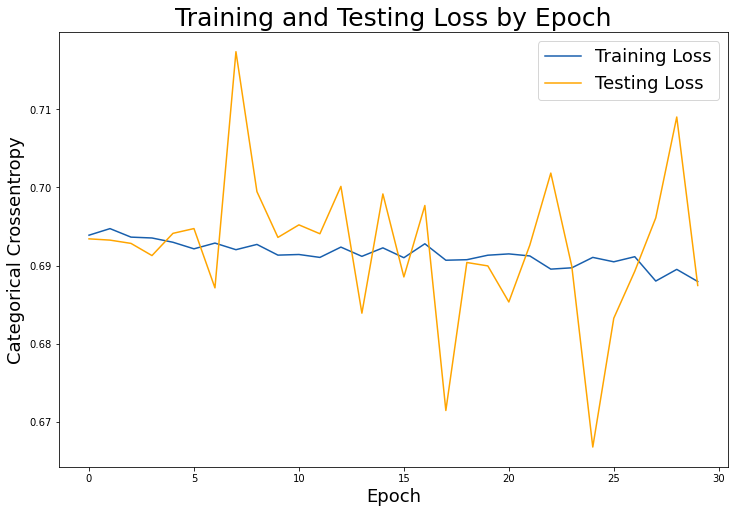

In [12]:
# Check out our train loss and test loss over epochs.
train_loss = results.history['loss']
test_loss = results.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

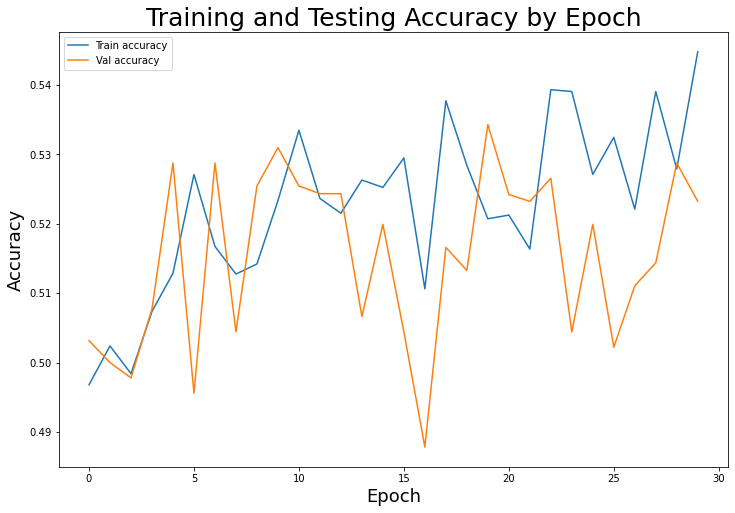

In [13]:
# Set figure size.
plt.figure(figsize=(12, 8))

plt.plot(results.history['accuracy'], label='Train accuracy')
plt.plot(results.history['val_accuracy'], label='Val accuracy')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.legend();

In [14]:
test_proba = model.predict_generator(test_image_gen)

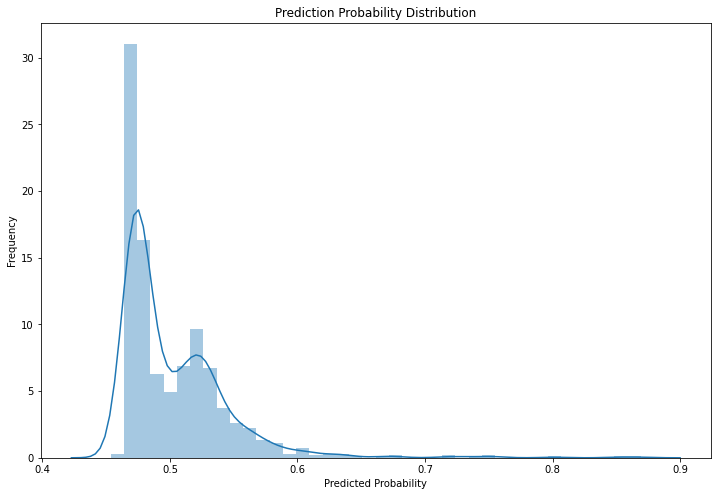

In [15]:
plt.figure(figsize=(12,8))
sns.distplot(test_proba)
plt.title('Prediction Probability Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency');